# 회귀 (Regression) 연습

## 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

## 데이터 읽기

    * 캘리포니아 내 주택에 대한 정보를 바탕으로 주택 가격을 예측

In [2]:
df = pd.read_csv('datasets/housing.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## EDA

In [3]:
df.shape

(20640, 10)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


    longitude : 경도
    latitude : 위도
    housing_median_age : 주택 나이(중앙값)
    total_rooms : 전체 방 수
    total_bedrooms : 전체 침실 수
    population : 인구 수
    households : 세대 수
    median_income : 소득(중앙값)
    median_house_value : 주택 가치(중앙값)
    ocean_proximity : 바다 근접도

    * 총 10개의 컬럼 중 ocean_proximity를 제외한 자료는 실수형 자료이며, ocean_proximity는 명목형 자료임.
      : 회귀 분석을 할 것이기 때문에 명목형 자료를 수치형 자료로 변환해주어야 함.
    * median_house_value 컬럼은 target label이 되는 값임.
    * total_bedrooms 컬럼에 207개의 null값이 있음.

In [5]:
df.isnull().sum().sum()

207

In [6]:
df['total_bedrooms'].isnull().sum()

207

In [7]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


    * 각 항목 값의 범위가 매우 큰 차이를 보임. => 정규화 작업 필요

### 결측치 처리

    * total_bedrooms의 데이터에서 207개의 결측치가 확인되었음. 결측치가 포함된 데이터들을 제거하는 방법으로 결측치를 처리할 수 있지만, 
      데이터의 수가 2만개 수준이며, 결측치를 갖는 데이터가 1% 수준이기 때문에 제거하는 방법은 바람직하지 못함.
      => 다른 변수와의 관계를 파악한 후, 상관도가 높은 값을 이용해서 결측치 값을 예측하고자 함.

In [8]:
df.iloc[:,:-2].corr().loc[:,'total_bedrooms']

longitude             0.069608
latitude             -0.066983
housing_median_age   -0.320451
total_rooms           0.930380
total_bedrooms        1.000000
population            0.877747
households            0.979728
median_income        -0.007723
Name: total_bedrooms, dtype: float64

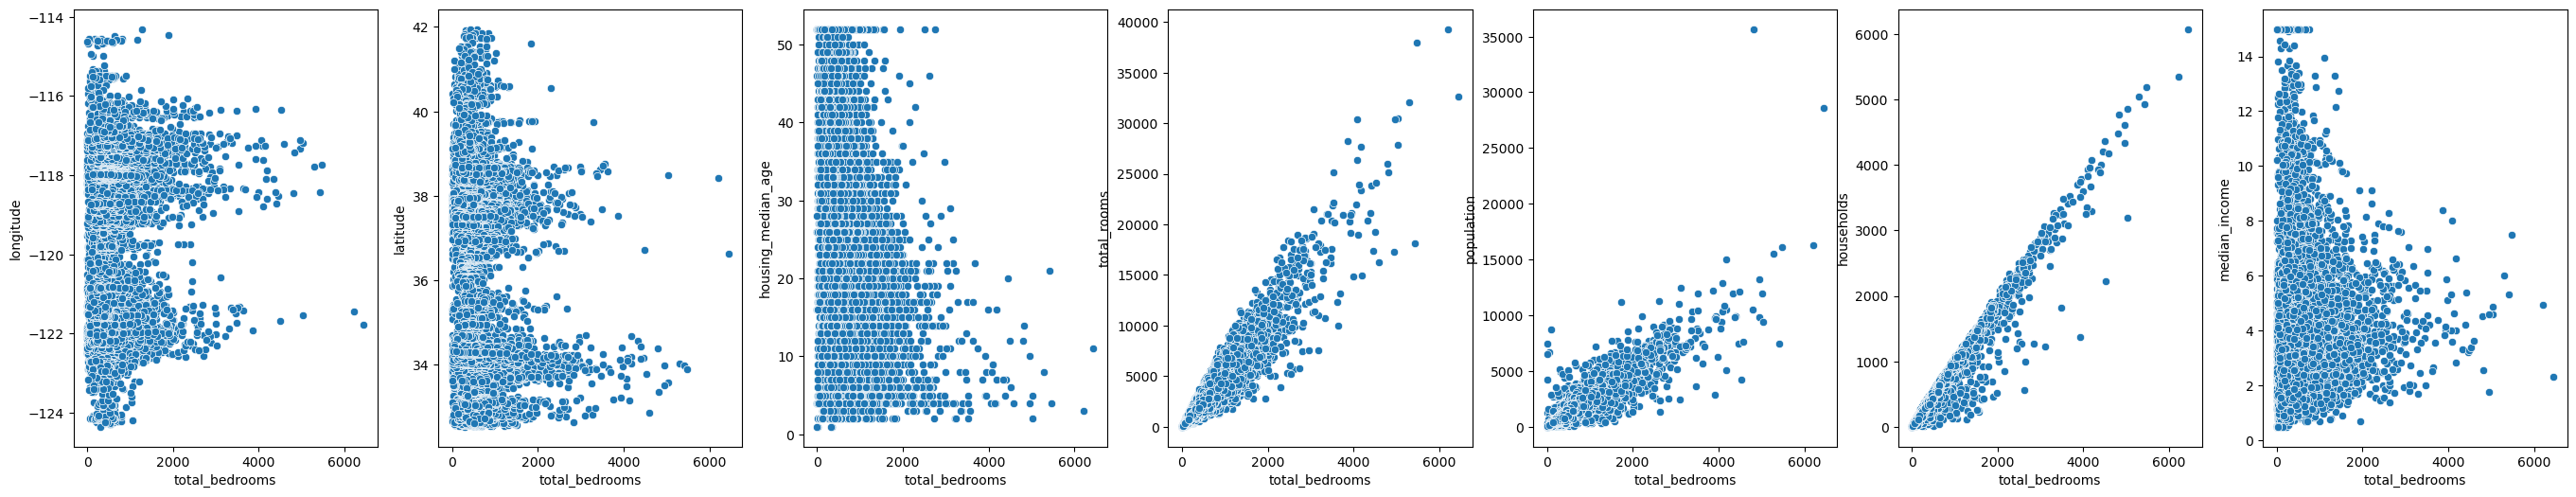

In [9]:
col_names = ['longitude','latitude','housing_median_age','total_rooms','population','households','median_income']

fig, axes = plt.subplots(ncols = 7)
fig.set_size_inches(34,6)

for i in range(7):
    sns.scatterplot(x = df.total_bedrooms, y = df[col_names[i]], ax = axes[i])

    * total bedrooms(전체 침실수)과의 상관 관계를 보면, households(세대수)와 가장 높은 상관도를 보인다. 하지만, 지역 내 세대수와 
      전체 침실수와의 상관관계가 높은 이유에 대해서는 설명이 조금 어려워 보임.
    * total rooms와 total bedrooms간의 상관관계가 households와의 상관관계보다는 조금 낮은 값이지만, 0.93 수준으로 높은 상관 관계를
      보이고 논리적으로도 설명이 더 잘되는 것으로 생각함.
      => total bedrooms의 결측치 예상은 total rooms의 데이터를 이용하여 예측하여 채워넣고자 함.

#### 선형회귀를 이용한 결측치 처리

    * Total rooms를 X값, Total bedrooms를 y값으로 나누어 줌
    * null값이 없는 데이터를 train data로, null값이 있는 데이터를 test data로 분류

In [10]:
X_train = df[df['total_bedrooms'].notnull()].loc[:,['total_rooms']]
X_train.shape

(20433, 1)

In [11]:
X_test = df[df['total_bedrooms'].isnull()].loc[:,['total_rooms']]
X_test.shape

(207, 1)

In [12]:
y_train = df[df['total_bedrooms'].notnull()]['total_bedrooms']
y_train.shape

(20433,)

In [13]:
## 선형회귀 
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
print(f'{lin_reg.score(X_train,y_train):.3f}')
print(f'{lin_reg.coef_[0]}, {lin_reg.intercept_}')

0.866
0.17940488381943728, 64.86881686430655


In [14]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [15]:
# df.where(True)인 경우는 원래 값을 유지, df.where(False)인 경우는 값 대체
df['total_bedrooms'].where(df['total_bedrooms'].notnull(), df['total_rooms']*lin_reg.coef_[0] + lin_reg.intercept_, inplace = True)
df.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

    * 결측치가 모두 채워진 것을 확인하였음.

In [16]:
df.iloc[:,:-2].corr().loc[:,'total_bedrooms']

longitude             0.068562
latitude             -0.066216
housing_median_age   -0.321304
total_rooms           0.930799
total_bedrooms        1.000000
population            0.877379
households            0.978644
median_income        -0.005910
Name: total_bedrooms, dtype: float64

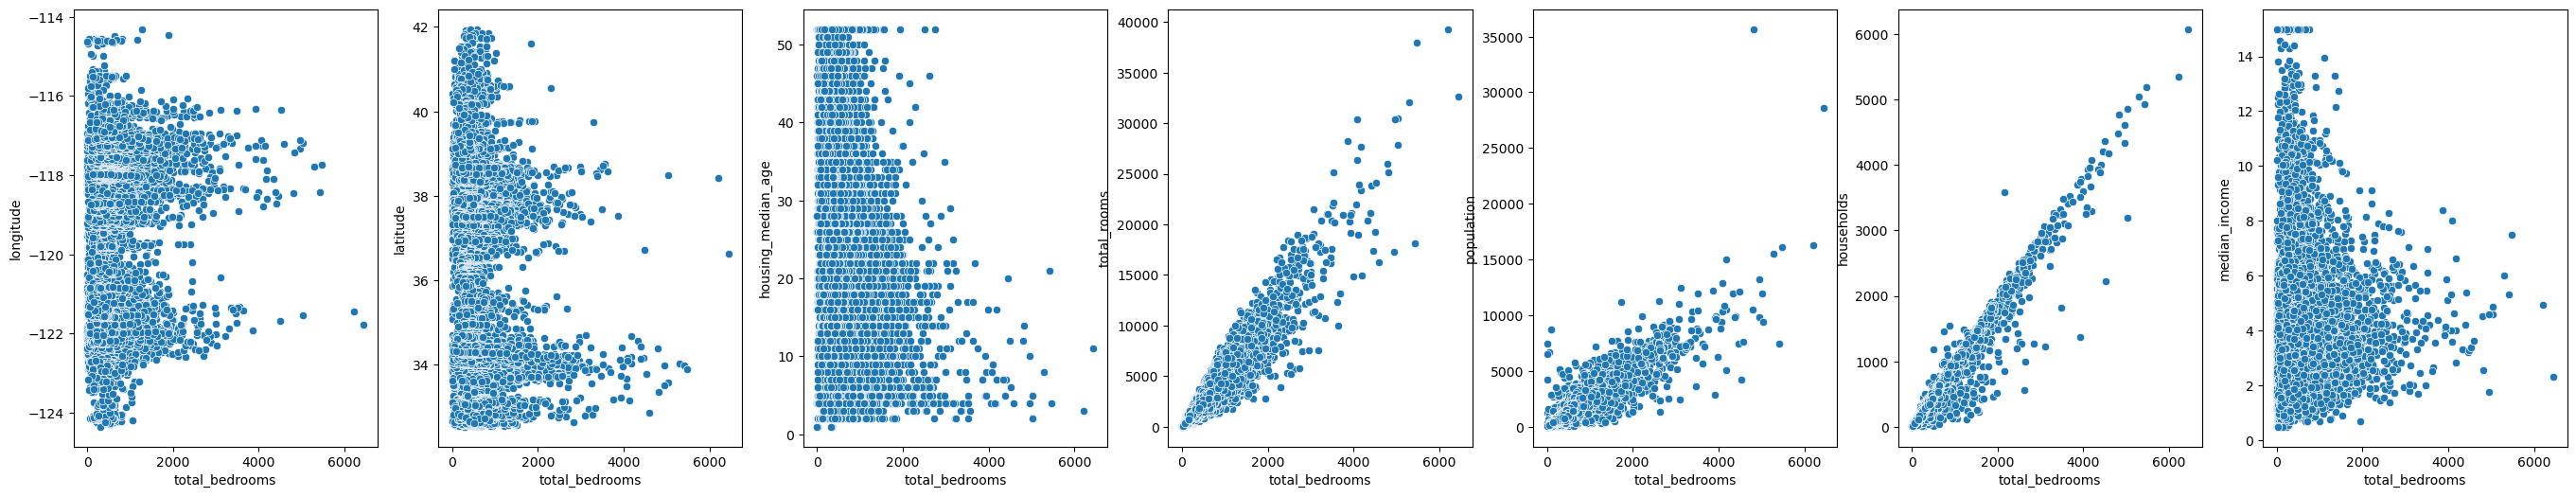

In [17]:
col_names = ['longitude','latitude','housing_median_age','total_rooms','population','households','median_income']

fig, axes = plt.subplots(ncols = 7)
fig.set_size_inches(34,6)

for i in range(7):
    sns.scatterplot(x = df.total_bedrooms, y = df[col_names[i]], ax = axes[i])

    * 결측치 값이 채워졌음에도 다른 값들과의 상관관계는 유사 수준으로 보임. 
      : 결측치를 total rooms값을 이용해서 채운 것이 전체 데이터의 경향에 영향을 주지 않았음을 확인.

### 이상치(outlier) 확인

In [18]:
# 변수가 되는 meadian_income까지를 새로운 dataframe에 저장
df_num = df.iloc[:,:-2]
df_num.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462


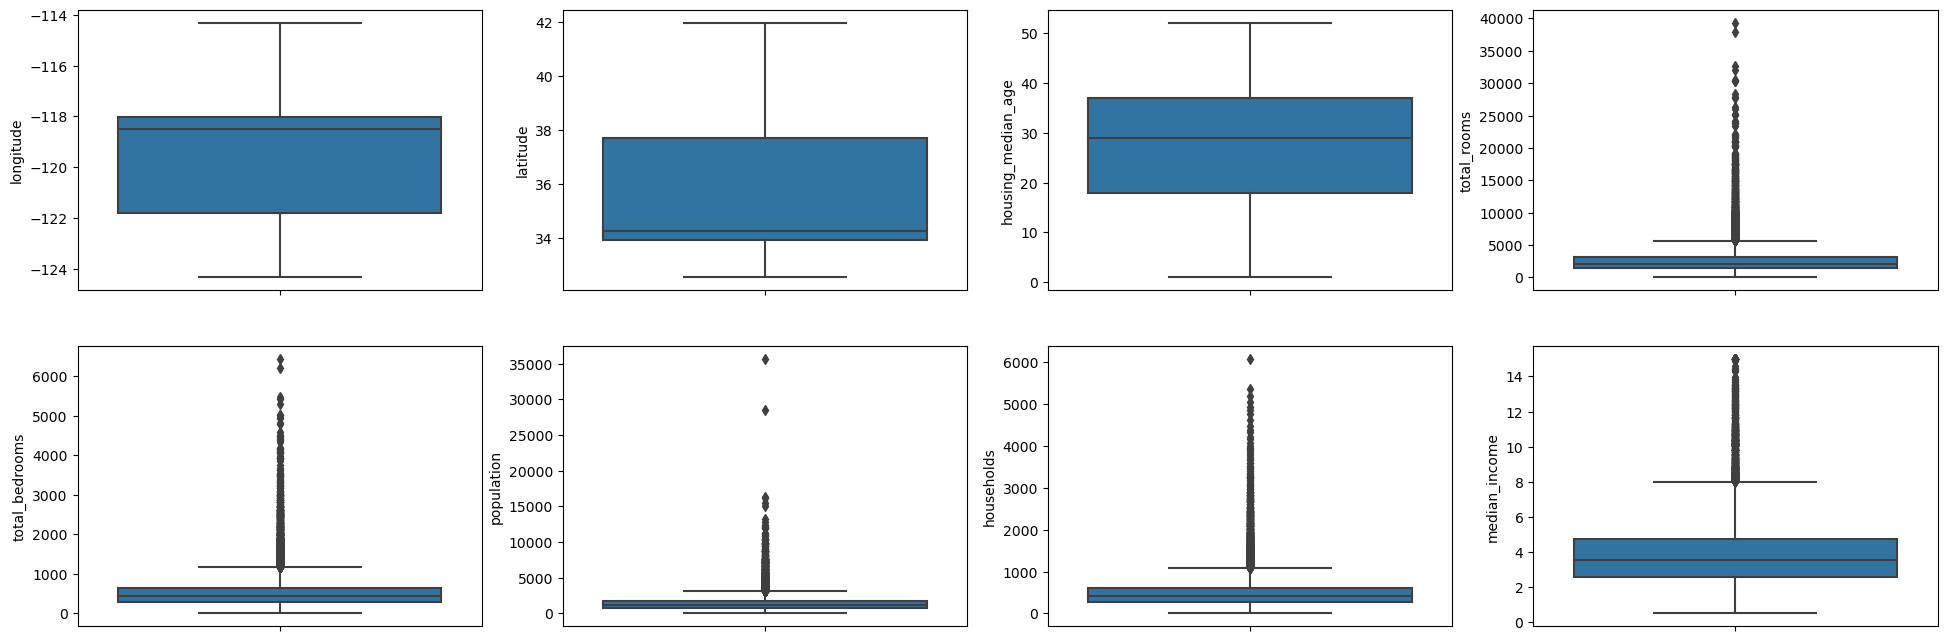

In [19]:
df_num_cols = df_num.columns
fig, axes = plt.subplots(nrows = 2, ncols = 4)
fig.set_size_inches(24, 8)

a = 0
for i in range(2):
    for j in range(4):
        sns.boxplot(data = df_num, y = df_num_cols[a], ax = axes[i][j])
        a += 1

    * total_rooms, total_bedrooms, population, households, median_income에서 이상값(outlier)가 확인되었음.

### 이상치(outlier) 처리

    * 1분위수, 3분위수에서 각각 1.5 IQR 범위 밖의 값들을 이상치로 보고 boundary값으로 변환

In [20]:
df_num.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.737586,1425.476744,499.539680,3.870671
std,2.003532,2.135952,12.585558,2181.615252,420.490677,1132.462122,382.329753,1.899822
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100


In [21]:
# Q1, Q3, IQR값을 통해 lowerB값과 upperB값을 계산
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3-Q1
lowerB = Q1 - 1.5*IQR
upperB = Q3 + 1.5*IQR

In [22]:
print(f'outlier 처리전: {np.where((df_num > upperB)|(df_num<lowerB))[0].shape}')

df_num_after = pd.DataFrame(np.where(df_num > upperB, upperB, np.where(df_num<lowerB, lowerB, df_num)), columns = df.columns[:-2])

print(f'outlier 처리후: {np.where((df_num_after > upperB)|(df_num_after<lowerB))[0].shape}')

outlier 처리전: (5664,)
outlier 처리후: (0,)


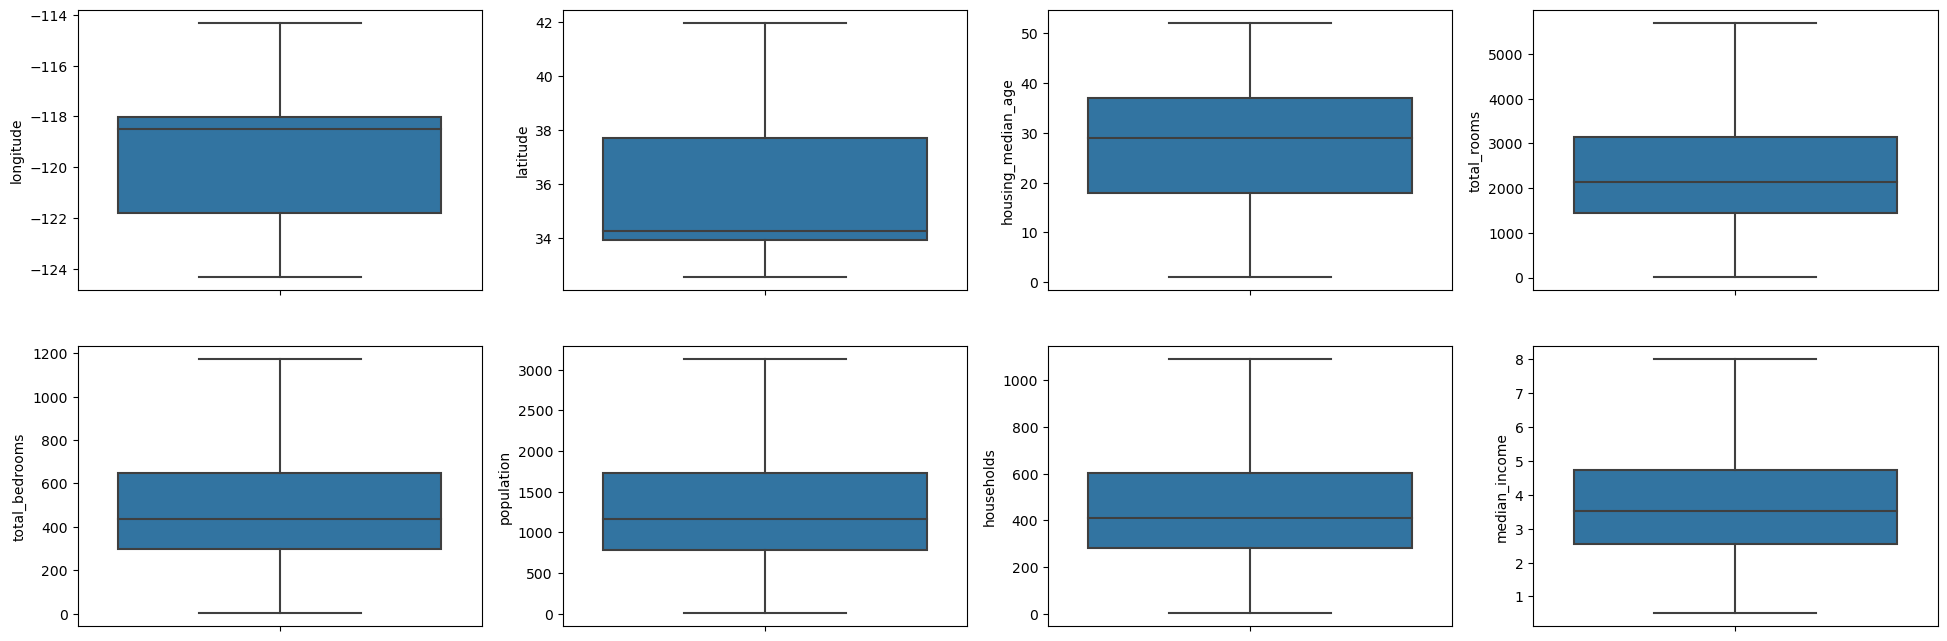

In [26]:
df_num_cols = df_num.columns
fig, axes = plt.subplots(nrows = 2, ncols = 4)
fig.set_size_inches(24, 8)

a = 0
for i in range(2):
    for j in range(4):
        sns.boxplot(data = df_num_after, y = df_num_cols[a], ax = axes[i][j])
        a += 1

    * outlier값들이 제거 되었음을 확인.

### 명목형 데이터 수치화

    * ocean_proximity의 값을 dummy value를 이용해서 수치형 데이터로 변환하고자 함.

In [27]:
set(df['ocean_proximity'])

{'<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'}

In [32]:
df_ocean = pd.get_dummies(df['ocean_proximity'], drop_first= True)
df_ocean.head()

,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0
4,0,0,1,0


    * 5개의 종류로 나누어져 있는 명목형 자료를 4개의 수치형 자료로 변환 (n개의 분류 -> n-1개의 수치형 자료)

In [34]:
# 이상치를 제거한 데이터와 수치화한 ocean_proximity를 합쳐서 X만들어 줌.
X = pd.concat([df_num_after, df_ocean], axis = 1)
X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.000,129.0,322.0,126.0,8.013025,0,0,1,0
1,-122.22,37.86,21.0,5698.375,1106.0,2401.0,1092.5,8.013025,0,0,1,0
2,-122.24,37.85,52.0,1467.000,190.0,496.0,177.0,7.257400,0,0,1,0
3,-122.25,37.85,52.0,1274.000,235.0,558.0,219.0,5.643100,0,0,1,0
4,-122.25,37.85,52.0,1627.000,280.0,565.0,259.0,3.846200,0,0,1,0


In [35]:
y = df['median_house_value']

In [36]:
X.shape

(20640, 12)

In [37]:
y.shape

(20640,)

## feature engineering

In [45]:
from sklearn.preprocessing import StandardScaler

### 데이터 정규화

In [39]:
X.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2441.692472,502.622504,1336.959012,469.020107,3.801010,0.317393,0.000242,0.110950,0.128779
std,2.003532,2.135952,12.585558,1397.790038,286.962572,765.550830,265.507540,1.657658,0.465473,0.015563,0.314077,0.334963
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.000000,0.000000,0.000000,0.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,0.000000,0.000000,0.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,0.000000,0.000000,0.000000,0.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,1.000000,0.000000,0.000000,0.000000
max,-114.310000,41.950000,52.000000,5698.375000,1173.500000,3132.000000,1092.500000,8.013025,1.000000,1.000000,1.000000,1.000000


    * 수치형 자료들의 값들의 scale 차이가 있기 때문에, 정규화 과저을 거치지 않으면 scale 차이로 인해 무시되어 버리는 값들이 발생할 것으로 예상.
      => 정규화 진행

In [44]:
std_scaler = StandardScaler()
X_norm = std_scaler.fit(X)
X_norm = std_scaler.transform(X)

### 훈련, 테스트 데이터셋 분리

In [46]:
from sklearn.model_selection import train_test_split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size = 0.25, random_state=0)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15480, 12) (15480,)
(5160, 12) (5160,)


## 회귀

### 선형회귀

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
print(f'train score: {lr.score(X_train, y_train)}')
print(f'test score: {lr.score(X_test, y_test)}')
print(f'MSE: {mean_squared_error(y_test, y_pred_lr)}')
print(f'R2 score: {r2_score(y_test, y_pred_lr)}')

train score: 0.6662021783403076
test score: 0.6585919182741221
MSE: 4512904961.584298
R2 score: 0.6585919182741221


    * MSE와 R2 score결과를 보았을 때, 선형회귀의 예측 성능은 높지 않은 것으로 생각된다.

### 다중 선형 회귀

    * 일반 선형회귀로는 예측 성능이 높지 않은 것으로 보여, 다중 선형회귀를 적용해서 평가하기로 함.

In [58]:
from sklearn.preprocessing import PolynomialFeatures

poly_2 = PolynomialFeatures(degree = 2)
poly_3 = PolynomialFeatures(degree = 3)

X_train_poly_2 = poly_2.fit_transform(X_train)
X_test_poly_2 = poly_2.fit_transform(X_test)
X_train_poly_3 = poly_3.fit_transform(X_train)
X_test_poly_3 = poly_3.fit_transform(X_test)

In [59]:
lr_poly_2 = LinearRegression()
lr_poly_2.fit(X_train_poly_2, y_train)
y_pred_lr_poly_2 = lr_poly_2.predict(X_test_poly_2)
print(f'train score: {lr_poly_2.score(X_train_poly_2, y_train)}')
print(f'test score: {lr_poly_2.score(X_test_poly_2, y_test)}')
print(f'MSE: {mean_squared_error(y_test, y_pred_lr_poly_2)}')
print(f'R2 score: {r2_score(y_test, y_pred_lr_poly_2)}')

train score: 0.7410638090293817
test score: -97050254136.71883
MSE: 1.2828594191650933e+21
R2 score: -97050254136.71883


In [60]:
lr_poly_3 = LinearRegression()
lr_poly_3.fit(X_train_poly_3, y_train)
y_pred_lr_poly_3 = lr_poly_3.predict(X_test_poly_3)
print(f'train score: {lr_poly_3.score(X_train_poly_3, y_train)}')
print(f'test score: {lr_poly_3.score(X_test_poly_3, y_test)}')
print(f'MSE: {mean_squared_error(y_test, y_pred_lr_poly_3)}')
print(f'R2 score: {r2_score(y_test, y_pred_lr_poly_3)}')

train score: 0.7867506116348181
test score: -1.2223587279900113e+20
MSE: 1.615775684188751e+30
R2 score: -1.2223587279900113e+20


    * 다중 선형회귀를 사용한 경우 train score는 단순 선형회귀를 이용한 경우보다 높아졌으나, MSE와 R2 score가 큰 값으로 증가/감소하였음.
      : R2 score가 0~1사이 위치하는 것을 생각한다면, 큰 음수로 나온 다중 선형회귀는 사용하기 어려워 보임.
        (왜 큰 음수값으로 나오는지는 공부가 필요할 것 같음)

### Ridge

In [68]:
from sklearn.linear_model import Ridge

rd = Ridge(alpha = 0.5)
rd.fit(X_train, y_train)
y_pred_rd = rd.predict(X_test)
print(f'train score: {rd.score(X_train, y_train)}')
print(f'test score: {rd.score(X_test, y_test)}')
print(f'MSE: {mean_squared_error(y_test, y_pred_rd)}')
print(f'R2 score: {r2_score(y_test, y_pred_rd)}')

train score: 0.6662021479323819
test score: 0.6585966826636864
MSE: 4512841983.469677
R2 score: 0.6585966826636864


### Lasso

In [63]:
from sklearn.linear_model import Lasso

ls = Lasso(alpha=0.1)
ls.fit(X_train, y_train)
y_pred_ls = ls.predict(X_test)
print(f'train score: {ls.score(X_train, y_train)}')
print(f'test score: {ls.score(X_test, y_test)}')
print(f'MSE: {mean_squared_error(y_test, y_pred_ls)}')
print(f'R2 score: {r2_score(y_test, y_pred_ls)}')

train score: 0.666202178247733
test score: 0.6585921266597905
MSE: 4512902207.036978
R2 score: 0.6585921266597905


    * Ridge, Lasso를 적용한 경우에도 단순 선형회귀와는 큰 성능 차이를 보이지 않았다.
      : 선형회귀 모델이 적합하지 않은 것인지, 데이터 전처리가 선형회귀에 적합하지 않았는지는 고민이 필요해 보임.

### DecisionTree

In [73]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(criterion='squared_error', splitter = 'best')
tree_reg.fit(X_train, y_train)
y_pred_tree_reg = tree_reg.predict(X_test)
print(f'train score: {tree_reg.score(X_train, y_train)}')
print(f'test score: {tree_reg.score(X_test, y_test)}')
print(f'MSE: {mean_squared_error(y_test, y_pred_tree_reg)}')
print(f'R2 score: {r2_score(y_test, y_pred_tree_reg)}')

train score: 1.0
test score: 0.6409120890811913
MSE: 4746605899.422093
R2 score: 0.6409120890811913


    * 트리 모델을 사용한 경우, train score값에서는 선형회귀와는 다르게 1로 나왔으나 test score에서는 0.64로 나타남.
      : 과적합이 발생하였으며, test 성능에서는 선형회귀와 큰 차이가 없는 것으로 보임.